1) Валідація двох альтернатив: additive VS multiplicative;
2) Описова частина (Moving Average, Exponential Smoothing, Differencing, Stationarity);
3) Валідація двох альтернатив приведення до стаціонарного ряду: decomposition VS differencing;
4) Тренування та валідація MA, AR, ARMA, ARIMA моделей;
5) Генерація фіч та валідація ML моделей (тут на Ваш смак будь-які з відомих регресивних моделей). Буде вважатися плюсом додавання додаткових екзогенних факторів, таких як опади, площі і тп.
6) Висновки щодо того, яку модель краще використовувати;
7) Прогноз на наступний рік
8) На основі одержаного прогнозу планування ресурсів на наступний рік, використовуючи додаткову інформацію:
На 3 тони врожаю потрібно залучити 1 працівника
Працівників можна наймати, використовуючи 3 типи контрактів:
i) 3 місячний термін, страховий збір 300 у.о. на початку, мзп 1000 у.о. 
ii) 4 місячний термін, щомісячний страховий збір 110 у.о., мзп 900 у.о 
iii) 7 місячний термін, щомісячний страховий збір 110 у.о. перші 3 місяці і 90 у.о. наступні 4 місяці, бонус по завершенні контракту 100 у.о. 800 мзп

In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5
from statsmodels.tsa.seasonal import seasonal_decompose

/home/maria/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
production = pd.read_csv('data/production_good.csv')
rainfall = pd.read_csv('data/rainfall_good.csv')
area = pd.read_csv('data/area_good.csv')

In [3]:
RAINFALL_LAGS = [6, 7, 8, 9, 10, 11, 12]
PRODUCTION_LAGS = [6, 7, 8, 9, 10, 11, 12]

def process_data(production, rainfall, area, REGIONS, PRODUCTION_LAGS, RAINFALL_LAGS):
    output = {}
    for i, region in enumerate(REGIONS):
        data = production[production.Region == region[0]]
        data = pd.merge(data[['Year', 'Month', 'Production', 'Diff_production']],
                        rainfall[rainfall.Region == region[1]][['Year', 'Month', 'Rainfall']], 
                        on=['Year', 'Month'], how='left')

        data = pd.merge(data, area[area.Region == region[2]][
            ['Year', 'Area_ma', 'Area_npa', 'Area_rpa', 'Area_New', 'Area_ma_new']], on='Year', how='left')
            
        data['Year'] = data['Year'].astype(int)
        data['Month'] = data['Month'].astype(int)
        data.reset_index(inplace=True)

        data.set_index([pd.to_datetime(['{0}-{1}-01'.format(x, y) for (x, y) in zip(data.Year, data.Month)])],
                       inplace=True)

        data.drop(['index', 'Year', 'Area_New', 'Diff_production'], axis=1, inplace=True)
        data['Time'] = np.arange(len(data))

        for lag in RAINFALL_LAGS:
            temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Rainfall.values[:-lag]))
            data['Rainfall_{0}'.format(lag)] = temp

        for lag in PRODUCTION_LAGS:
            temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Production.values[:-lag]))
            data['Production_{0}'.format(lag)] = temp
        
        PRODUCTION = data.Production
        data.drop(['Production'], axis=1, inplace=True)

        data.fillna(data.mean(), inplace=True)

        #  And finally drop rainfalls
        data.drop(['Rainfall'], axis=1, inplace=True)
        ### HERE I CAN ADD FEATURE ENGINEERING!!!

        #  And clip first year
        for col in data.columns:
            data['_'.join([region[1], str(col)])] = data[col]
            data.drop([col], axis=1, inplace=True)
        
        output[region[1]] = (data[max(PRODUCTION_LAGS):], PRODUCTION[max(PRODUCTION_LAGS):])
    return output

data = process_data(production, rainfall, area,  [['PRK', 'Perak', 'PRK']], PRODUCTION_LAGS, RAINFALL_LAGS)

In [4]:
data.keys(), type(data['Perak'][0]), type(data['Perak'][1])

(dict_keys(['Perak']), pandas.core.frame.DataFrame, pandas.core.series.Series)

In [5]:
data['Perak'][0].head()

,Perak_Month,Perak_Area_ma,Perak_Area_npa,Perak_Area_rpa,Perak_Area_ma_new,Perak_Time,Perak_Rainfall_6,Perak_Rainfall_7,Perak_Rainfall_8,Perak_Rainfall_9,Perak_Rainfall_10,Perak_Rainfall_11,Perak_Rainfall_12,Perak_Production_6,Perak_Production_7,Perak_Production_8,Perak_Production_9,Perak_Production_10,Perak_Production_11,Perak_Production_12
1999-01-01,1,262.0,303.0,2.0,143.3,12,139.76,85.43,217.63,99.72,77.90,57.48,109.84,102.732,92.812,83.162,75.789,76.202,75.258,64.054
1999-02-01,2,262.0,303.0,2.0,143.3,13,183.15,139.76,85.43,217.63,99.72,77.90,57.48,104.759,102.732,92.812,83.162,75.789,76.202,75.258
1999-03-01,3,262.0,303.0,2.0,143.3,14,139.21,183.15,139.76,85.43,217.63,99.72,77.90,95.395,104.759,102.732,92.812,83.162,75.789,76.202
1999-04-01,4,262.0,303.0,2.0,143.3,15,224.90,139.21,183.15,139.76,85.43,217.63,99.72,82.394,95.395,104.759,102.732,92.812,83.162,75.789
1999-05-01,5,262.0,303.0,2.0,143.3,16,278.00,224.90,139.21,183.15,139.76,85.43,217.63,74.966,82.394,95.395,104.759,102.732,92.812,83.162


In [6]:
data['Perak'][0].index

DatetimeIndex(['1999-01-01', '1999-02-01', '1999-03-01', '1999-04-01',
               '1999-05-01', '1999-06-01', '1999-07-01', '1999-08-01',
               '1999-09-01', '1999-10-01',
               ...
               '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01',
               '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
               '2017-08-01', '2017-09-01'],
              dtype='datetime64[ns]', length=225, freq=None)

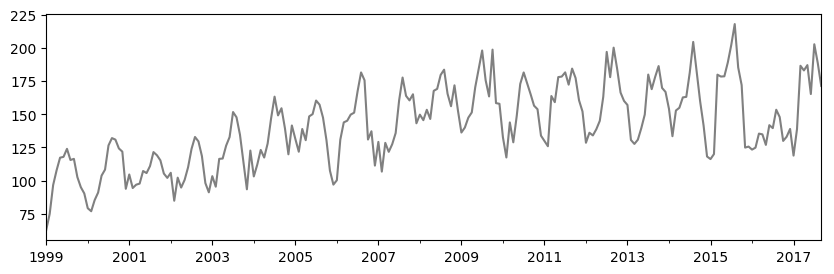

In [7]:
(data['Perak'][1]).plot(figsize=(10,3), color='grey')

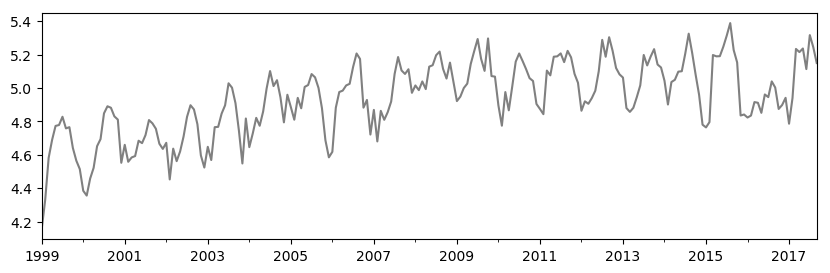

In [8]:
np.log1p(data['Perak'][1]).plot(figsize=(10,3), color='grey')

This series grows through time, more likely multiplicative

## Moving Average

Using sliding window of size n for calculating the average is called Moving Average technique. It forecasts the next value(s) in a time series based on the average of a fixed finite number of the previous values.

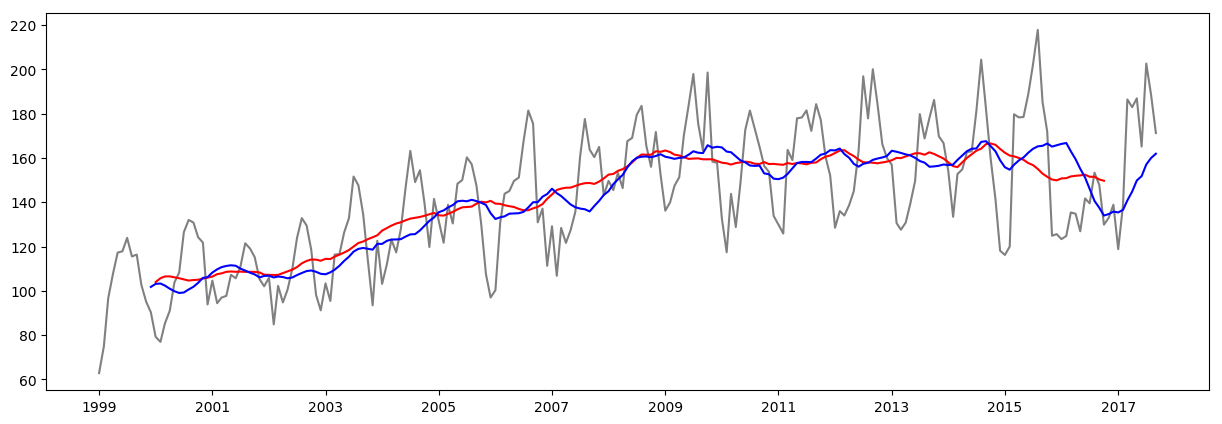

In [9]:
ts = data['Perak'][1]

ts_moving_avg_center = ts.rolling(24, center=True).mean()
ts_moving_avg_right = ts.rolling(12, center=False).mean()
plt.plot(ts, color='grey')
plt.plot(ts_moving_avg_center, color='red')
plt.plot(ts_moving_avg_right, color='blue')

## Exponential Smoothing

It may be useful to give larger weights to more recent observations than to observations from the distant past. This is called exponential smoothing. Forecasts are calculated using weighted averages where the weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations.

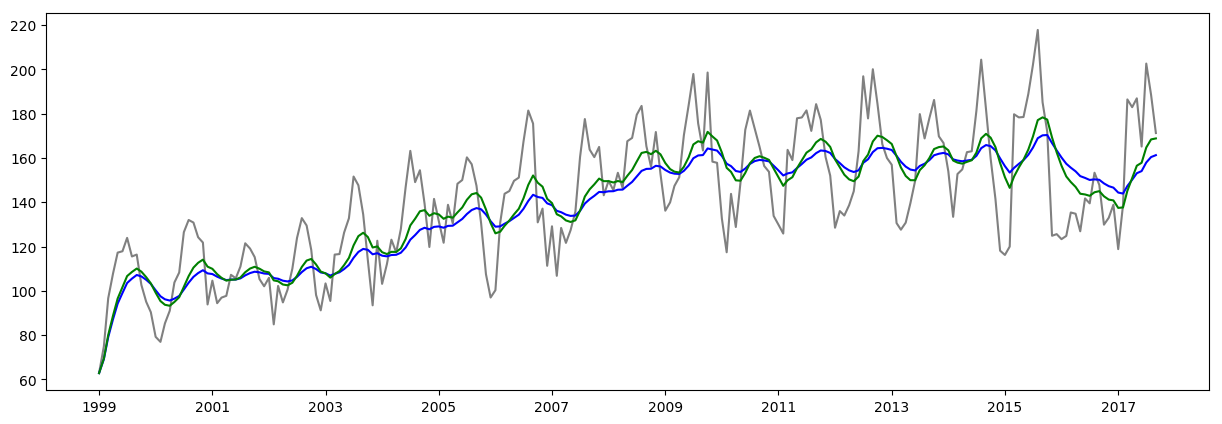

In [10]:
ts = data['Perak'][1]

ts_ewm_24 = ts.ewm(span=24).mean()  
ts_ewm_12 = ts.ewm(span=12).mean()
plt.plot(ts, color='grey')
plt.plot(ts_ewm_24, color='blue')
plt.plot(ts_ewm_12, color='green')
plt.show()

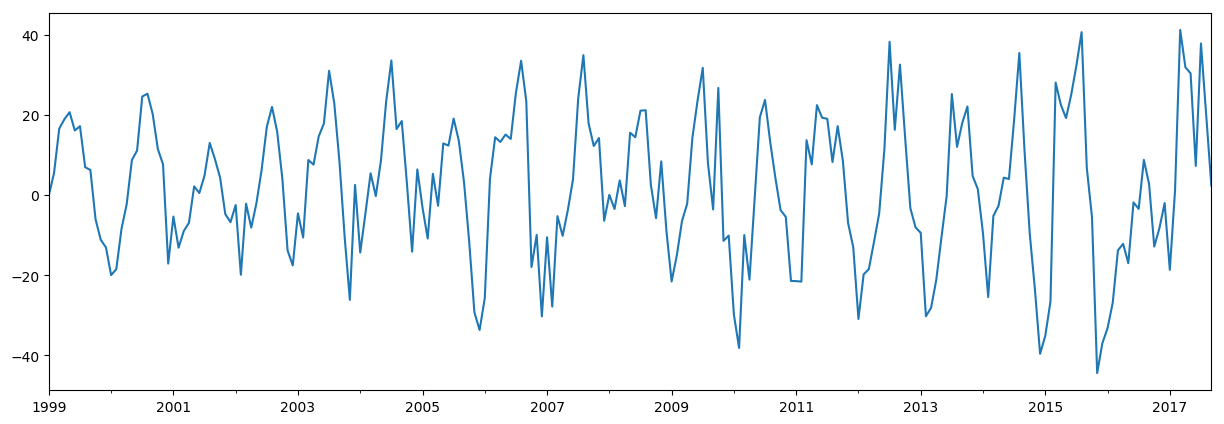

In [11]:
(ts - ts_ewm_12).plot()

## Differencing

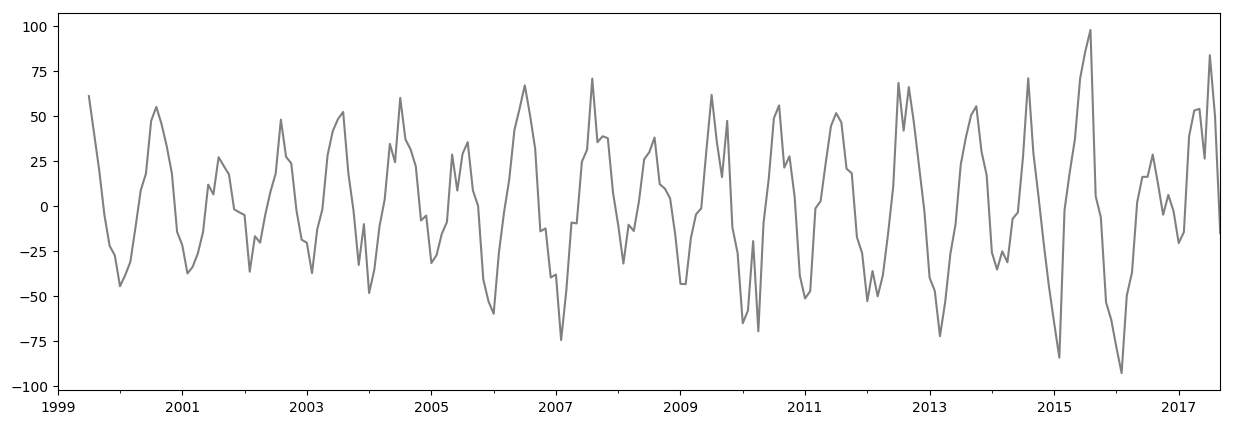

In [12]:
ts_diff = ts - ts.shift(6)  # 1 month shift
ts_diff.plot(color='grey')

## Stationarity

In [13]:
from statsmodels.tsa.stattools import adfuller
def stationarity_test(ts):
    # Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(ts, autolag='AIC')
    print(dftest)     
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [14]:
stationarity_test(ts)

Results of Dickey-Fuller Test:
(-1.7146375759543186, 0.4235869748171478, 12, 212, {'1%': -3.4615775784078466, '5%': -2.8752718989837249, '10%': -2.5740891037735847}, 1690.3573181497773)
Test Statistic                  -1.714638
p-value                          0.423587
#Lags Used                      12.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


In [15]:
stationarity_test(ts - ts_ewm_12)

Results of Dickey-Fuller Test:
(-5.2279074704452899, 7.7090238369174492e-06, 13, 211, {'1%': -3.4617274344627398, '5%': -2.8753374677799957, '10%': -2.5741240890815571}, 1616.7834379473907)
Test Statistic                  -5.227907
p-value                          0.000008
#Lags Used                      13.000000
Number of Observations Used    211.000000
Critical Value (1%)             -3.461727
Critical Value (5%)             -2.875337
Critical Value (10%)            -2.574124
dtype: float64


In [16]:
ts_diff.dropna(inplace=True)
stationarity_test(ts_diff)

Results of Dickey-Fuller Test:
(-6.3805057304363393, 2.2284278476244452e-08, 11, 207, {'1%': -3.4623415245233145, '5%': -2.875606128263243, '10%': -2.5742674398469041}, 1673.9473064831841)
Test Statistic                -6.380506e+00
p-value                        2.228428e-08
#Lags Used                     1.100000e+01
Number of Observations Used    2.070000e+02
Critical Value (1%)           -3.462342e+00
Critical Value (5%)           -2.875606e+00
Critical Value (10%)          -2.574267e+00
dtype: float64


The more negative this statistic, the more likely we are to reject the null hypothesis, and more likely we have a stationary dataset.
Statistic value of -5.8 is less than the value of -3.46 at 1%. It means that we can reject the null hypothesis with a significance level of less than 1% that the time series is stationary. 

## Decomposition vs. Differencing

Mode:  multiplicative


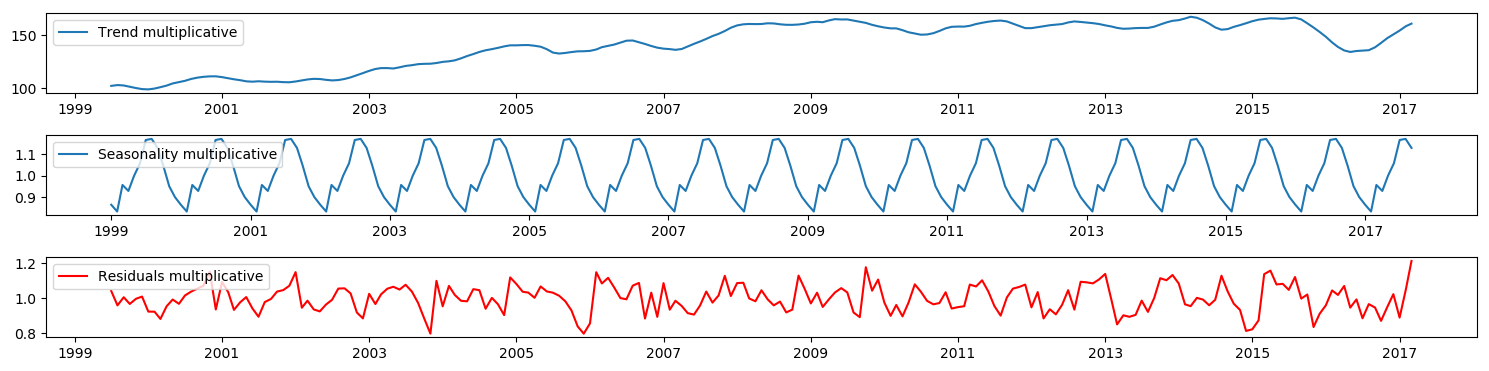

Mode:  additive


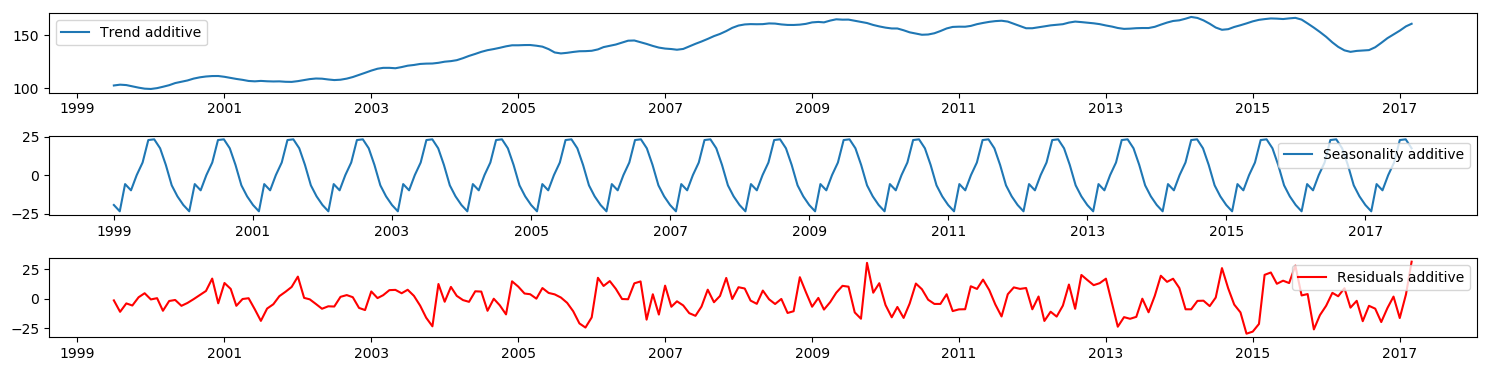

In [17]:
def _decompose(ts, freq, mode):
    decomposition = seasonal_decompose(ts, freq=freq, model=mode)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    print("Mode: ", mode)
    plt.subplot(412)
    plt.plot(trend, label='Trend '+mode)
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality '+mode)
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals '+mode, color='red')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    return trend, seasonal, residual

# multiplicative seasonal decomposition
trend_mul, seasonal_mul, residual_mul = _decompose(data['Perak'][1], 12, 'multiplicative')

# additive seasonal decomposition
trend_add, seasonal_add, residual_add = _decompose(data['Perak'][1], 12, 'additive')

If the seasonal variation is relatively constant over time, we can use the additive structure for decomposing a given time series. But in this case seasonal variation is increasing over time, we can use the multiplicative structure for decomposing a time series.

In [18]:
residual_add.dropna(inplace=True)
residual_mul.dropna(inplace=True)
print("Results for additive:")
print(stationarity_test(residual_add))
print("----------------------------------------------------------------------")
print("Results for multiplicative: " )
print(stationarity_test(residual_mul))

Results for additive:
Results of Dickey-Fuller Test:
(-7.2674499711958145, 1.6210089767088316e-10, 14, 198, {'1%': -3.4638151713286316, '5%': -2.8762506321350432, '10%': -2.574611347821651}, 1467.4748789039916)
Test Statistic                -7.267450e+00
p-value                        1.621009e-10
#Lags Used                     1.400000e+01
Number of Observations Used    1.980000e+02
Critical Value (1%)           -3.463815e+00
Critical Value (5%)           -2.876251e+00
Critical Value (10%)          -2.574611e+00
dtype: float64
None
----------------------------------------------------------------------
Results for multiplicative: 
Results of Dickey-Fuller Test:
(-7.3015761878797116, 1.3343466125888553e-10, 14, 198, {'1%': -3.4638151713286316, '5%': -2.8762506321350432, '10%': -2.574611347821651}, -492.23079970367985)
Test Statistic                -7.301576e+00
p-value                        1.334347e-10
#Lags Used                     1.400000e+01
Number of Observations Used    1.980000

In this case multiplicative worked slightly better than additive and much better than differencing.
Decomposition is a better way to stationarize series as it removes seperately trend, cycle, seasonal effects. 

##### This series is multiplicative

### Metrics error

In [19]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## ARIMA models

In [20]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(residual_mul, nlags=10)
lag_pacf = pacf(residual_mul, nlags=10, method='ols')

By looking at the ACF and PACF plots of the differenced series, you can identify the numbers of AR and/or MA terms that are needed. 

[ 1.          0.3489524   0.11179883 -0.11735873 -0.27727792 -0.26741128
 -0.19283734 -0.14243056 -0.17751557 -0.04650757  0.04155673]


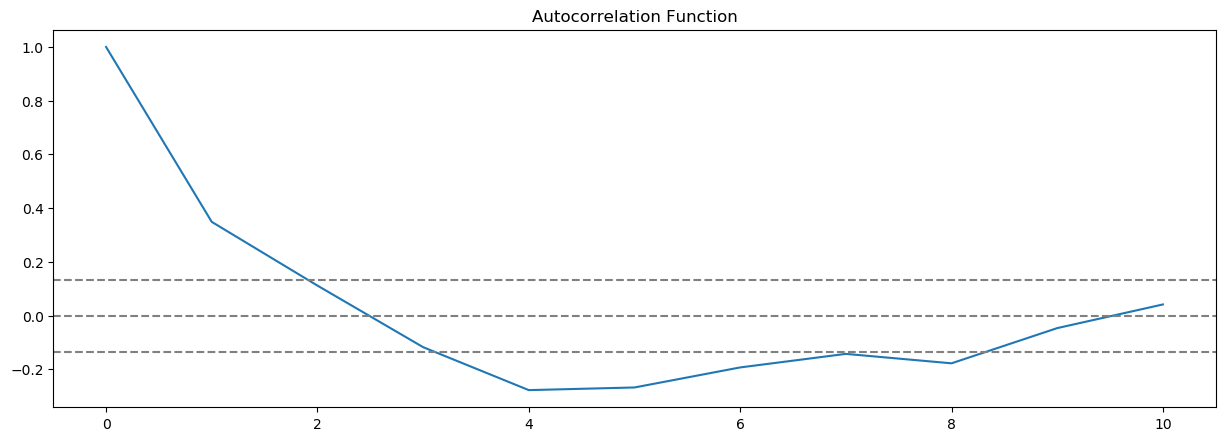

In [21]:
#Plot ACF: 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(residual_mul)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(residual_mul)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
print(lag_acf)

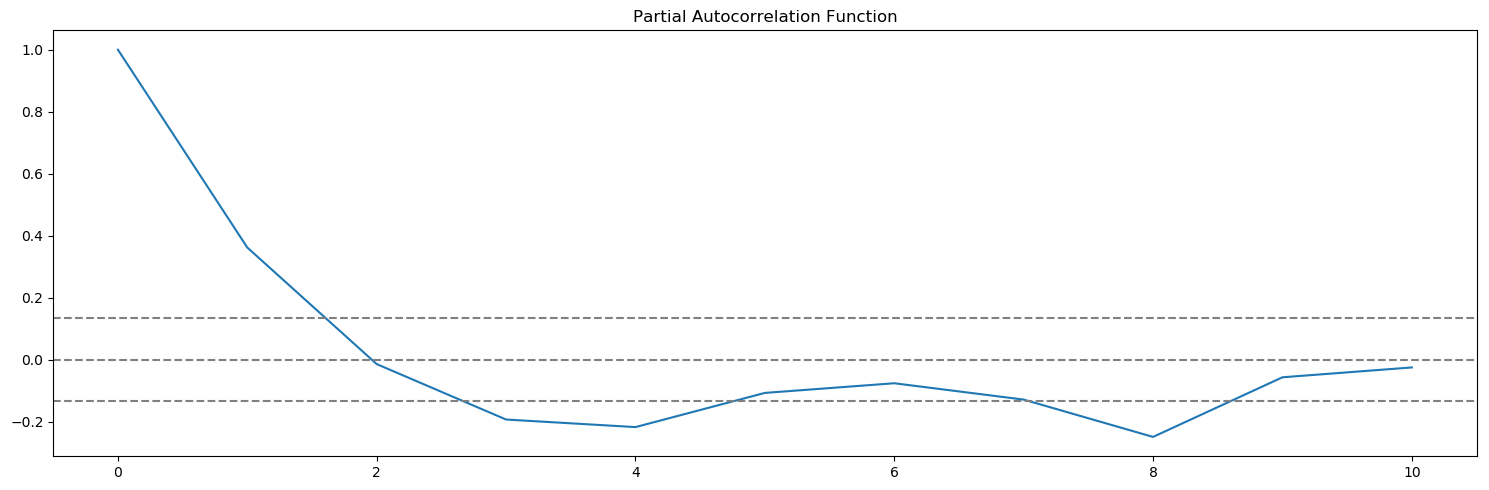

In [22]:
#Plot PACF:
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(residual_mul)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(residual_mul)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

The dotted lines define the confidence intereval, which determines the ‘p’ and ‘q’ :

p – lag value where the PACF chart crosses the upper confidence interval for the first time. In this case close to p=2. 
q – lag value where the ACF chart crosses the upper confidence interval for the first time. In this case q=2.

In [23]:
x_train = residual_mul[:-35]
x_test = residual_mul[-36:]

## MA model

/home/maria/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0.5,1,'MAPE: 5.2508')

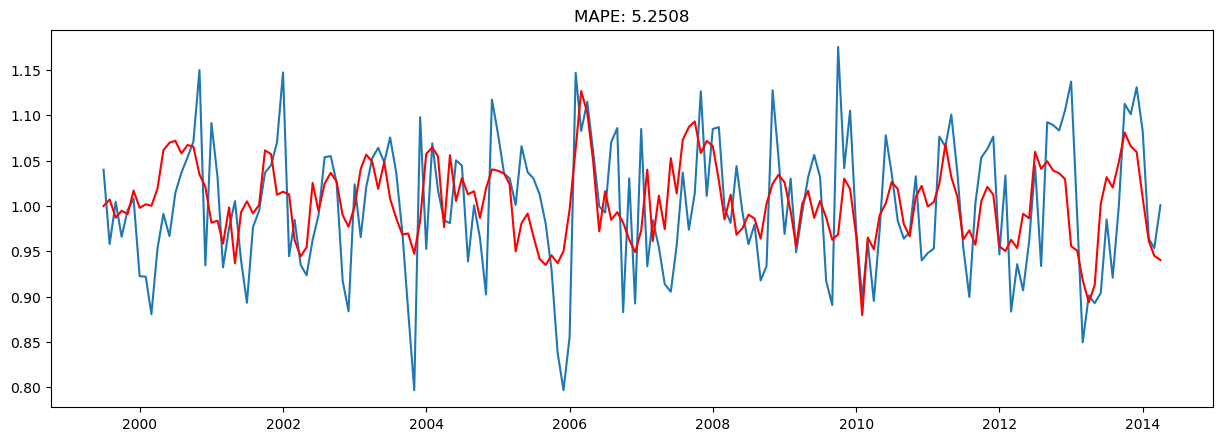

In [24]:
model = ARIMA(x_train, order=(0, 0, 4))  
results_MA = model.fit(disp=-1) 
plt.plot(x_train)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('MAPE: %.4f'% mean_absolute_percentage_error(x_train, results_MA.fittedvalues))

In [25]:
# results_MA.summary()

In [26]:
# Validation testing
forecast_ma = results_MA.predict(start=len(x_train), end=len(x_train)+len(x_test))
forecast_ma = forecast_ma.where(forecast_ma.notnull())

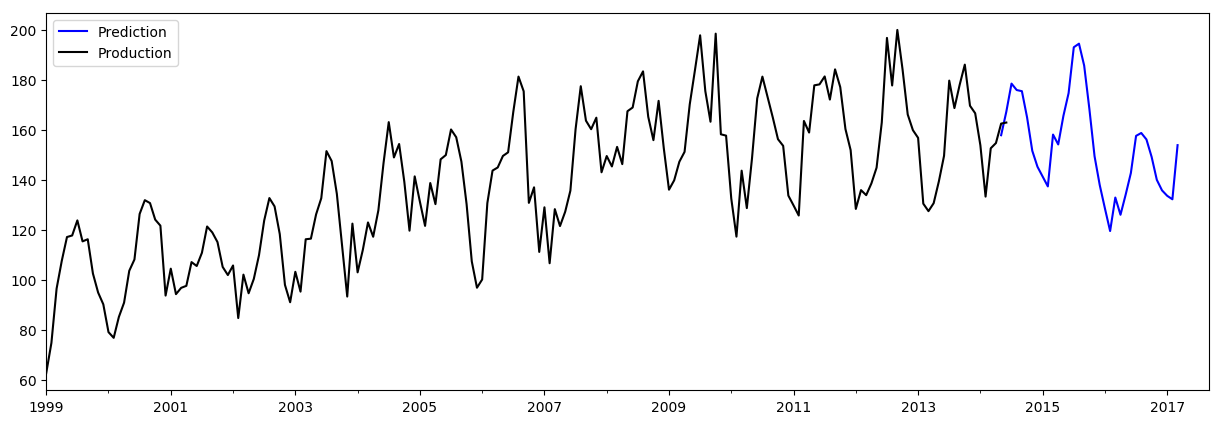

In [27]:
final_forecast = forecast_ma.mul(trend_mul).mul(seasonal_mul)
final_forecast.plot(color='blue', label='Prediction')
ts[:-39].plot(color='black')
plt.legend()

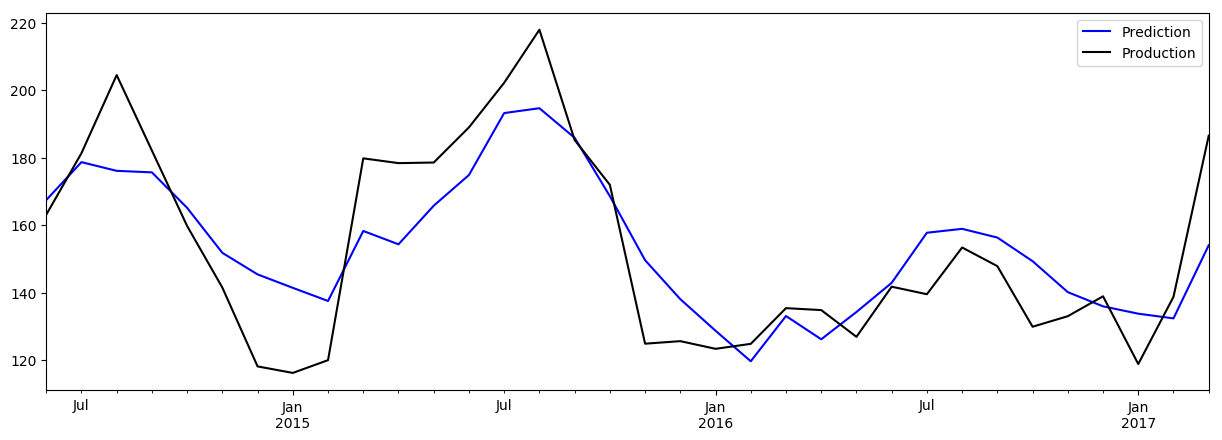

In [28]:
final_forecast[-40:-6].plot(color='blue', label='Prediction')
ts[-40:-6].plot(color='black')
plt.legend()

In [29]:
print("MAPError for MA model: ",mean_absolute_percentage_error(ts[-39:-6], final_forecast[-40:-6]))

MAPError for MA model:  8.448596043829745


## AR model

Text(0.5,1,'MAPE: 5.2499')

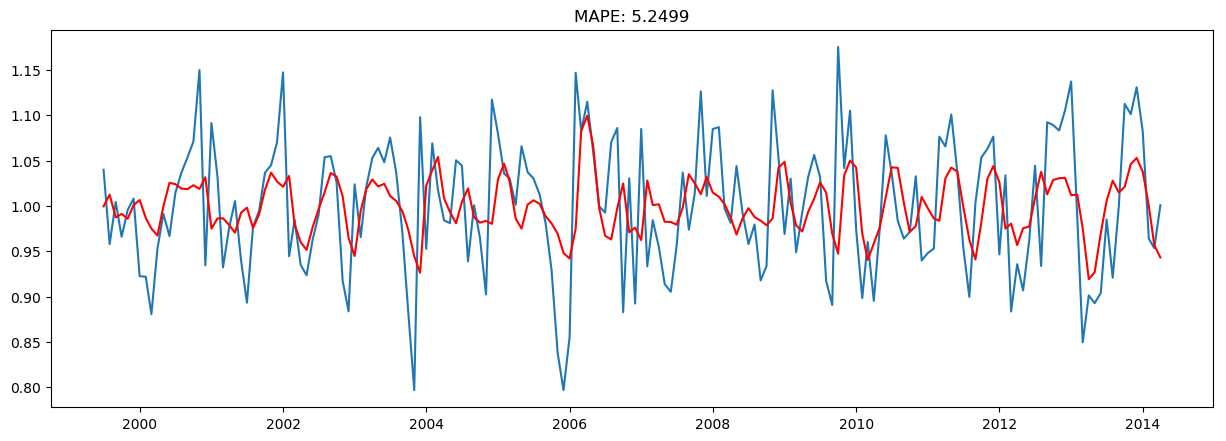

In [30]:
model = ARIMA(x_train, order=(5, 0, 0))  
results_AR = model.fit(disp=-1) 
plt.plot(x_train)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('MAPE: %.4f'% mean_absolute_percentage_error(x_train, results_AR.fittedvalues))

MAPError for AR model:  8.300299544616887


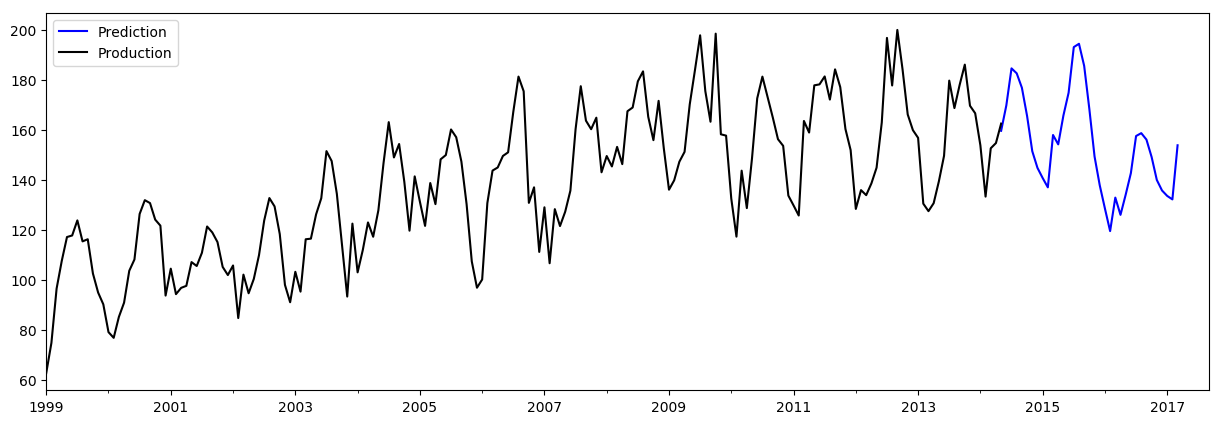

In [31]:
# Validation testing
forecast_ar = results_AR.predict(start=len(x_train), end=len(x_train)+len(x_test))
forecast_ar = forecast_ar.where(forecast_ar.notnull())

final_forecast = forecast_ar.mul(trend_mul).mul(seasonal_mul)
final_forecast.plot(color='blue', label='Prediction')
ts[:-40].plot(color='black')
plt.legend()

print("MAPError for AR model: ",mean_absolute_percentage_error(ts[-39:-6], final_forecast[-40:-6]))

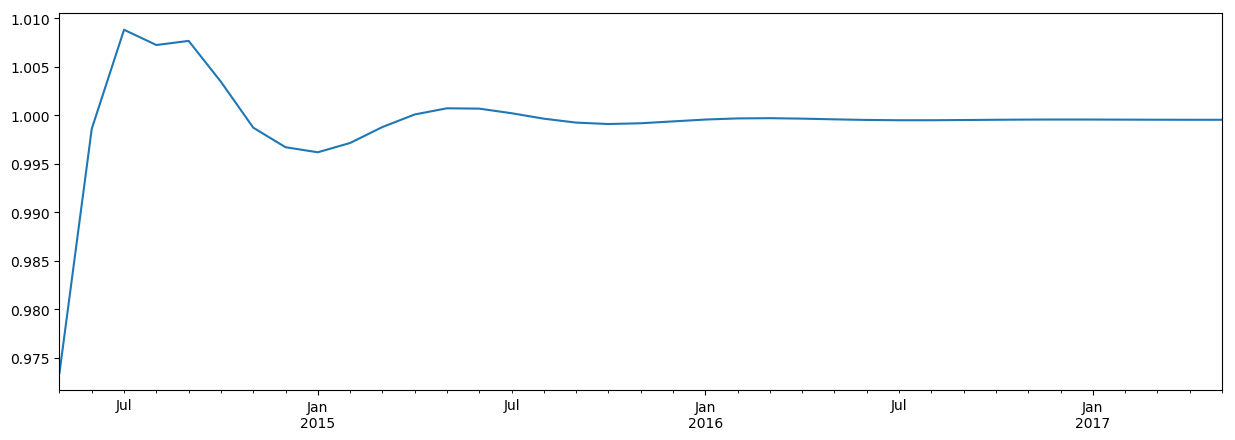

In [32]:
# Forecasted residuals
forecast_ar.plot()

## ARMA model

/home/maria/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0.5,1,'MAPE: 4.9736')

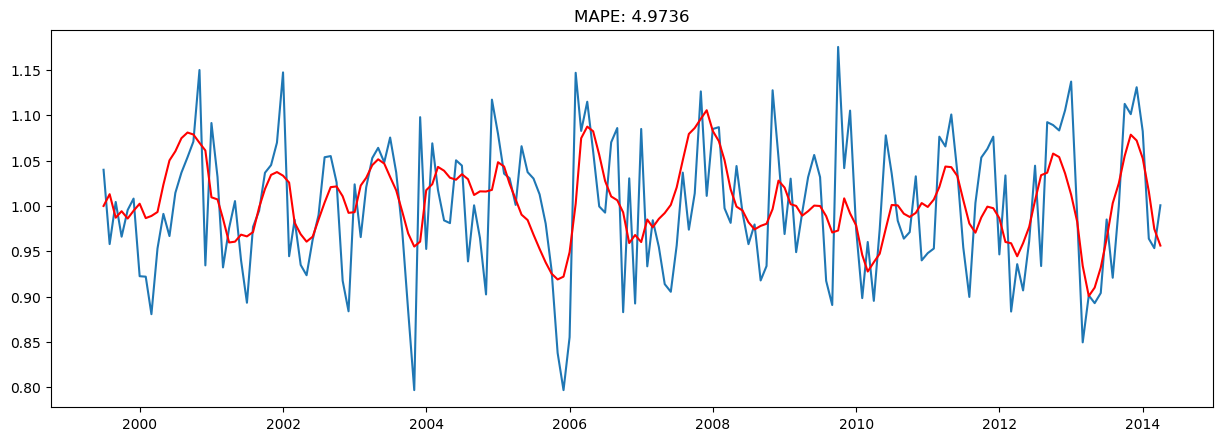

In [33]:
model = ARIMA(x_train, order=(2, 0, 2))  
results_ARMA = model.fit(disp=-1)  
plt.plot(x_train)
plt.plot(results_ARMA.fittedvalues, color='red')
plt.title('MAPE: %.4f'% mean_absolute_percentage_error(x_train, results_ARMA.fittedvalues))

MAPError for AR model:  8.764554549923002


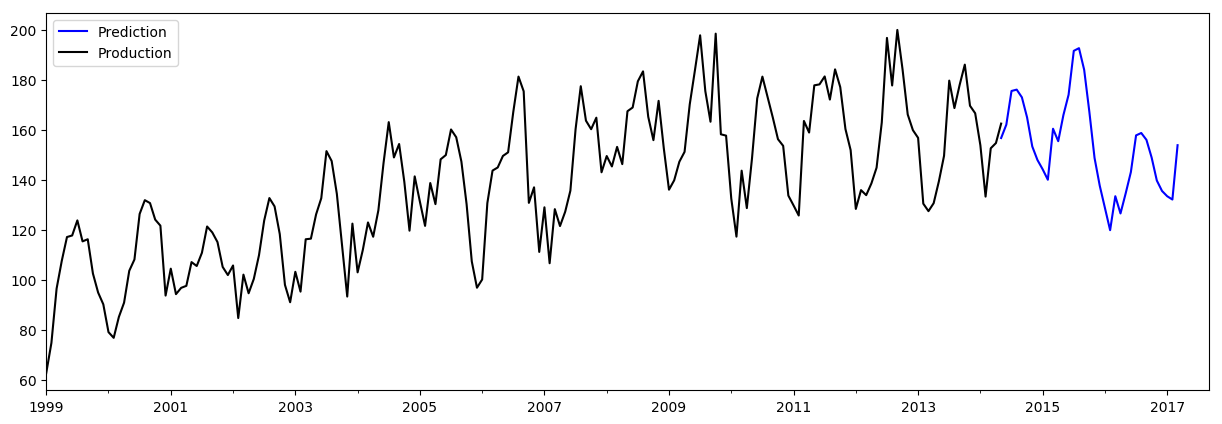

In [34]:
# Validation testing
forecast_arma = results_ARMA.predict(start=len(x_train), end=len(x_train)+len(x_test))
forecast_arma = forecast_arma.where(forecast_arma.notnull())

final_forecast = forecast_arma.mul(trend_mul).mul(seasonal_mul)
final_forecast.plot(color='blue', label='Prediction')
ts[:-40].plot(color='black')
plt.legend()

print("MAPError for AR model: ",mean_absolute_percentage_error(ts[-39:-6], final_forecast[-40:-6]))

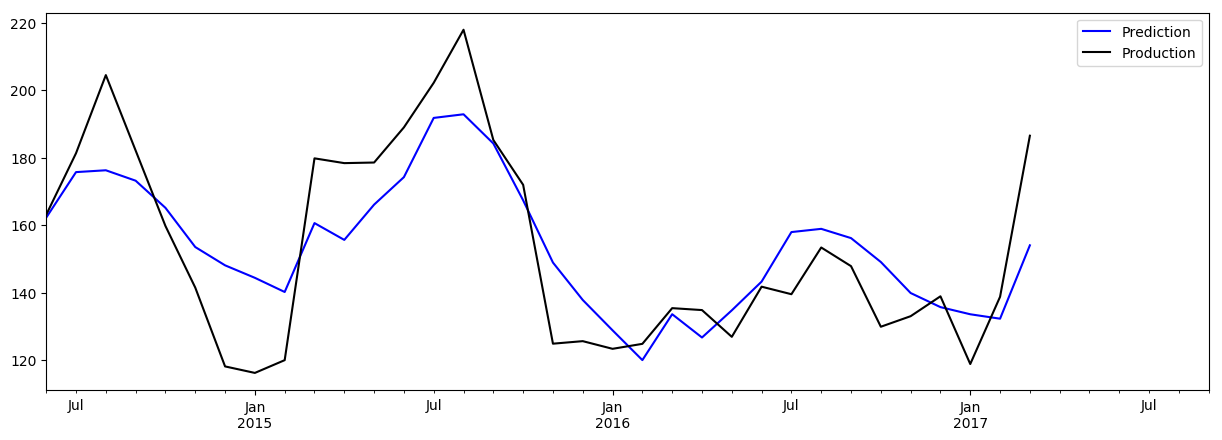

In [35]:
final_forecast = forecast_arma.mul(trend_mul).mul(seasonal_mul)
final_forecast[-40:].plot(color='blue', label='Prediction')
ts[-40:-6].plot(color='black')
plt.legend()

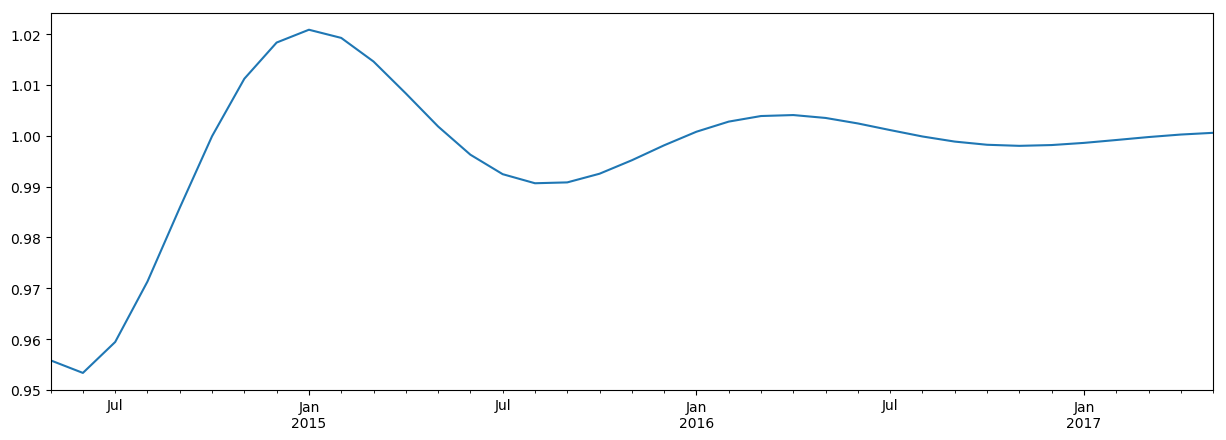

In [36]:
# forecasted residuals
forecast_arma.plot()

## ARIMA model

Text(0.5,1,'MAPE: 99.9005')

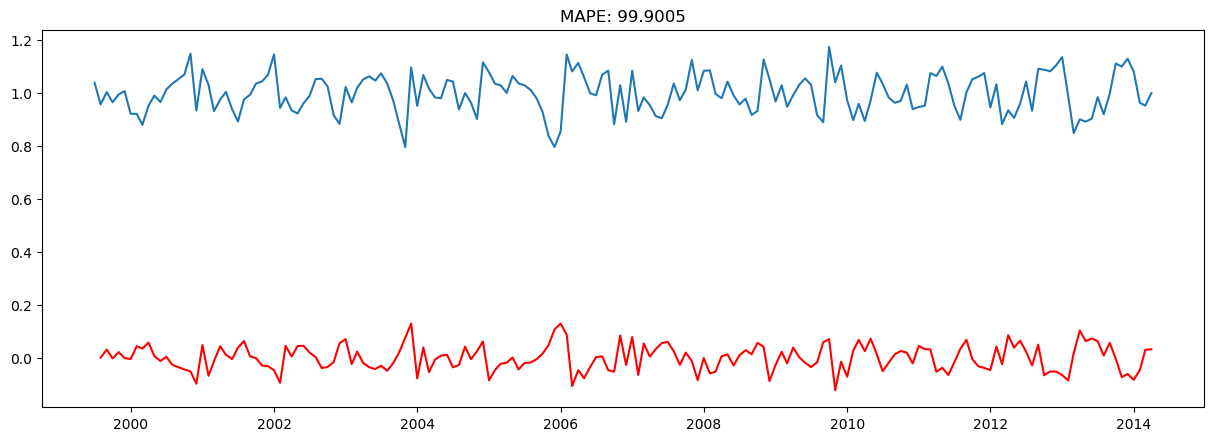

In [37]:
model = ARIMA(x_train, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1) 
plt.plot(x_train)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('MAPE: %.4f'% mean_absolute_percentage_error( x_train, results_ARIMA.fittedvalues))

ARMA model shows best results. We can see that the AR and MA models have almost the same MAPE but combined together they give smaller error on training set, however, on the test set ARMA model shows worse results. However, ARMA model is more general. It allows fitting certain nonstationary time series and even stationary series that cannot be fit by low order autoregressive models.
* p - number of autoregressive terms
* d - number of nonseasonal differences needed for stationarity
* q - number of lagged forecast errors in the prediction equation.

We have found prediciton of residuals by fitting train residuals, to return to original series we need to multiplicate(or add if it was decomposed additively) forecast by trend and seasonality. Seasonality will remain constant through time, nut trend needs to be forecasted linearly to create out of sample prediction.

Since we fitted already stationary series there is no need in d - term. Thus, ARMA, which combines both AR and MA, is a best option. The AR part indicates  the use of past values in the regression equation for the series and moving average component represents the error of the model as a combination of previous error terms.

## Machine learning models

In [38]:
from sklearn.linear_model import ElasticNet,LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import xgboost as xg

from dateutil.relativedelta import relativedelta

/home/maria/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [39]:
features = data['Perak'][0]
series = np.log1p(data['Perak'][1])

In [40]:
features.head()

,Perak_Month,Perak_Area_ma,Perak_Area_npa,Perak_Area_rpa,Perak_Area_ma_new,Perak_Time,Perak_Rainfall_6,Perak_Rainfall_7,Perak_Rainfall_8,Perak_Rainfall_9,Perak_Rainfall_10,Perak_Rainfall_11,Perak_Rainfall_12,Perak_Production_6,Perak_Production_7,Perak_Production_8,Perak_Production_9,Perak_Production_10,Perak_Production_11,Perak_Production_12
1999-01-01,1,262.0,303.0,2.0,143.3,12,139.76,85.43,217.63,99.72,77.90,57.48,109.84,102.732,92.812,83.162,75.789,76.202,75.258,64.054
1999-02-01,2,262.0,303.0,2.0,143.3,13,183.15,139.76,85.43,217.63,99.72,77.90,57.48,104.759,102.732,92.812,83.162,75.789,76.202,75.258
1999-03-01,3,262.0,303.0,2.0,143.3,14,139.21,183.15,139.76,85.43,217.63,99.72,77.90,95.395,104.759,102.732,92.812,83.162,75.789,76.202
1999-04-01,4,262.0,303.0,2.0,143.3,15,224.90,139.21,183.15,139.76,85.43,217.63,99.72,82.394,95.395,104.759,102.732,92.812,83.162,75.789
1999-05-01,5,262.0,303.0,2.0,143.3,16,278.00,224.90,139.21,183.15,139.76,85.43,217.63,74.966,82.394,95.395,104.759,102.732,92.812,83.162


In [41]:
# validation folds [last year, last two years, last three years, last four years, last five years]
folds, folds_temp = [], []
series_df = series.reset_index()

for fold in [2,3, 4, 5, 6]: 
    fold = series_df[:][series_df['index'] > pd.to_datetime('201'+str(fold)+'-09-01')][series_df['index'] < pd.to_datetime('201'+str(fold+1)+'-10-01')]  
    folds_temp.append(fold)

folds = [pd.concat(folds_temp[-i:]) for i in range(1, 6)]

[print(f.index)for f in folds]

Int64Index([213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224], dtype='int64')
Int64Index([201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213,
            214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224],
           dtype='int64')
Int64Index([189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
            202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214,
            215, 216, 217, 218, 219, 220, 221, 222, 223, 224],
           dtype='int64')
Int64Index([177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
            190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,
            203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215,
            216, 217, 218, 219, 220, 221, 222, 223, 224],
           dtype='int64')
Int64Index([165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
            178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
            191, 192, 193, 19

/home/maria/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


[None, None, None, None, None]

In [42]:
for i, fold in enumerate(folds):
    train_x, train_y = features.ix[-fold.index.min():], series[-fold.index.min():]
    test_x, test_y = features.ix[fold.index], fold
    print("Fold"+ str(i+1)+ "  ", str(i+1) + " validation years", train_x.shape, train_y.shape, test_x.shape, test_y.shape)

Fold1   1 validation years (213, 20) (213,) (12, 20) (12, 2)
Fold2   2 validation years (201, 20) (201,) (24, 20) (24, 2)
Fold3   3 validation years (189, 20) (189,) (36, 20) (36, 2)
Fold4   4 validation years (177, 20) (177,) (48, 20) (48, 2)
Fold5   5 validation years (165, 20) (165,) (60, 20) (60, 2)


/home/maria/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


## LinearRegression

In [43]:
folds_errors = []

for i, fold in enumerate(folds):
    train_x, train_y = features.iloc[:fold.index.min()+1], series[:fold.index.min()+1]
    test_x, test_y = features.ix[fold.index], fold['Production']
    model_lr = LinearRegression()
    model_lr.fit(train_x, train_y)

    test_y_predicted = model_lr.predict(test_x)
    
    mape_err = mean_absolute_percentage_error(np.exp(test_y), np.exp(test_y_predicted)) 
    print("LinearRegression error for "+str(i+1)+"fold : ", "%.5f" % mape_err)
    folds_errors.append(mape_err)
print("Average error: ", np.mean(folds_errors))

LinearRegression error for 1fold :  24.94535
LinearRegression error for 2fold :  20.79316
LinearRegression error for 3fold :  17.53128
LinearRegression error for 4fold :  14.63344
LinearRegression error for 5fold :  14.82986
Average error:  18.5466178703


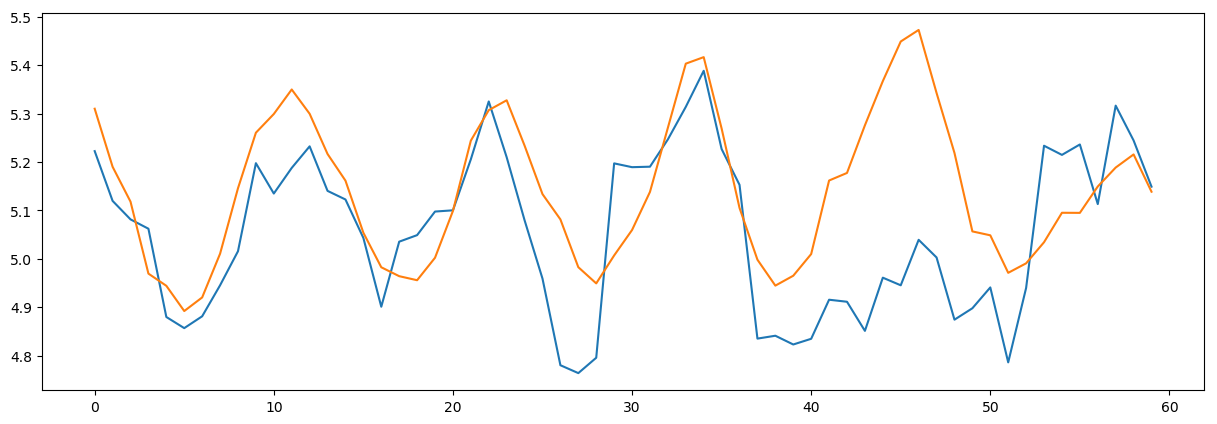

In [44]:
plt.plot(np.array(test_y))
plt.plot(test_y_predicted)
plt.show()

## ElasticNet

In [45]:
x, y = features.iloc[:folds[2].index.min()+1], series[:folds[2].index.min()+1]
x_, y_ = features.ix[folds[2].index], folds[2]['Production']

errors_elnet = []
for alpha in [2, 1, 0.1, 0.01, 0.001]:
    model_elnet = ElasticNet(alpha=alpha)
    model_elnet.fit(x, y)

    test_y_predicted = model_elnet.predict(x_)

    mape_err = mean_absolute_percentage_error(np.exp(y_), np.exp(test_y_predicted)) 
    print("ElasticNet error with alpha= ",alpha, "is: ",  mape_err)
    errors_elnet.append(mape_err)
print("Minimum mape error:", min(errors_elnet))

ElasticNet error with alpha=  2 is:  17.643149243259195
ElasticNet error with alpha=  1 is:  17.3779715077204
ElasticNet error with alpha=  0.1 is:  17.726226951017715
ElasticNet error with alpha=  0.01 is:  17.69464465195682
ElasticNet error with alpha=  0.001 is:  17.548752617920595
Minimum mape error: 17.3779715077204


Best result is for alpha = 0.01, now running validation

In [46]:
folds_errors = []

for i, fold in enumerate(folds):
    train_x, train_y = features.iloc[:fold.index.min()+1], series[:fold.index.min()+1]
    test_x, test_y = features.ix[fold.index], fold['Production']
    model_elnet = ElasticNet(alpha=1)
    model_elnet.fit(train_x, train_y)

    test_y_predicted = model_elnet.predict(test_x)
    mape_err = mean_absolute_percentage_error(np.exp(test_y), np.exp(test_y_predicted)) 
    print("ElasticNet error for "+str(i+1)+"fold : ", "%.5f" % mape_err)
    folds_errors.append(mape_err)
print("Average error: ", np.mean(folds_errors))

ElasticNet error for 1fold :  13.73894
ElasticNet error for 2fold :  18.40132
ElasticNet error for 3fold :  17.37797
ElasticNet error for 4fold :  14.24055
ElasticNet error for 5fold :  13.67091
Average error:  15.4859384057


## Ridge regression

In [47]:
folds_errors = []

for i, fold in enumerate(folds):
    train_x, train_y = features.iloc[:fold.index.min()+1], series[:fold.index.min()+1]
    test_x, test_y = features.ix[fold.index], fold['Production']
    model_lr = Ridge()
    model_lr.fit(train_x, train_y)

    test_y_predicted = model_lr.predict(test_x)
    
    mape_err = mean_absolute_percentage_error(np.exp(test_y), np.exp(test_y_predicted)) 
    print("RidgeRegression error for "+str(i+1)+"fold : ", "%.5f" % mape_err)
    folds_errors.append(mape_err)
print("Average error: ", np.mean(folds_errors))

RidgeRegression error for 1fold :  24.94324
RidgeRegression error for 2fold :  20.79302
RidgeRegression error for 3fold :  17.53168
RidgeRegression error for 4fold :  14.63366
RidgeRegression error for 5fold :  14.83015
Average error:  18.5463501613


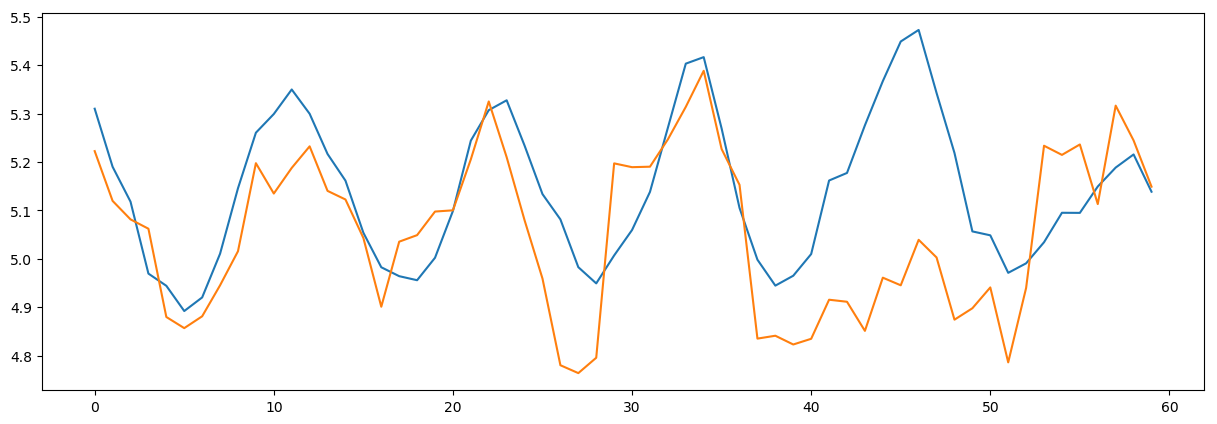

In [48]:
plt.plot(np.array(test_y_predicted))
plt.plot(np.array(test_y))
plt.show()

## XGBoost Regressor

In [49]:
folds_errors = []

for i, fold in enumerate(folds):
    train_x, train_y = features.iloc[:fold.index.min()+1], series[:fold.index.min()+1]
    test_x, test_y = features.ix[fold.index], fold['Production']
    
    clf = xg.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, min_child_weight=2 )
    clf.fit(train_x, train_y)
    prediction = clf.predict(test_x)
    mape_err = mean_absolute_percentage_error(np.exp(test_y), np.exp(prediction)) 
    print("XGBoost error for "+str(i+1)+"fold : ", "%.5f" % mape_err)
    folds_errors.append(mape_err)
print("Average error: ", np.mean(folds_errors))

XGBoost error for 1fold :  9.75720
XGBoost error for 2fold :  14.37406
XGBoost error for 3fold :  12.91122
XGBoost error for 4fold :  11.08966
XGBoost error for 5fold :  9.87730
Average error:  11.6018882022


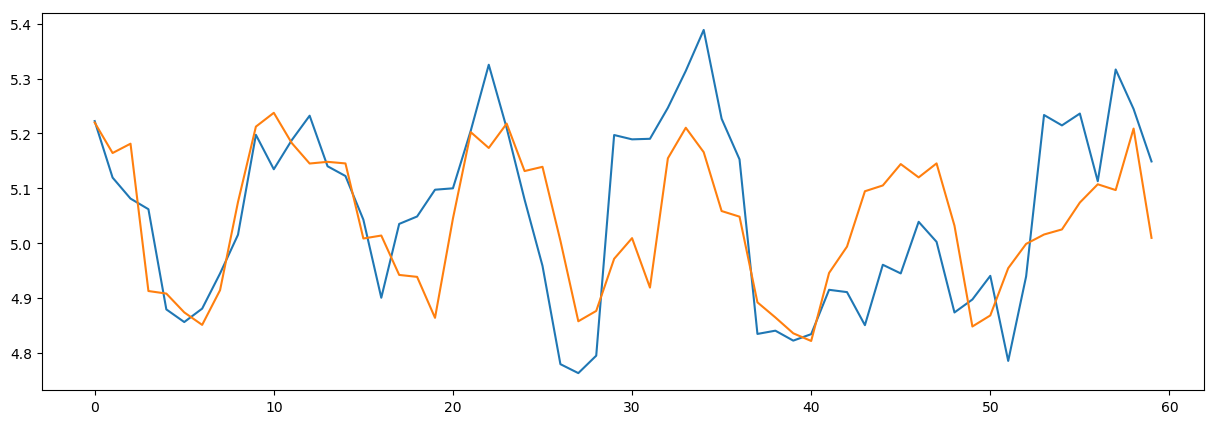

In [50]:
plt.plot(np.array(test_y))
plt.plot(prediction)
plt.show()

Models summary: All linear models give approximetely same results, it is difficult for them to make forecast.
Feature engineering is critical for boosting. One of the main disadvantages of boosting is that tree models do not extrapolate, while regression can be used to generalized cases. 
Best results on all folds is for XGBoost.
However, ARIMA works better than any of these machine learning models. That's because for only one series there is no need to train ml models, they will work better with more data. 

## Prediction for the next year

As long as we don't have features for the future prediction, we can't use ml models to forecast future year, but we can use fourie transform for this. 

In [51]:
def fourierExtrapolation(x, n_predict, harm):
    n = x.size
    restored_ind = x.index
    restored_ind = restored_ind.append(x.shift(n_predict, freq="MS").index[-n_predict:])
    n_harm = harm  # number of harmonics in model
    x_freqdom = np.fft.fft(x)  # detrended x in frequency domain
    f = np.fft.fftfreq(n)  # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key=lambda i: np.absolute(f[i]))

    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n  # amplitude
        phase = np.angle(x_freqdom[i])  # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return pd.Series(data=restored_sig, index=restored_ind)

restored_fourier = fourierExtrapolation(ts, 12, 36) # prediction for the next 12 month

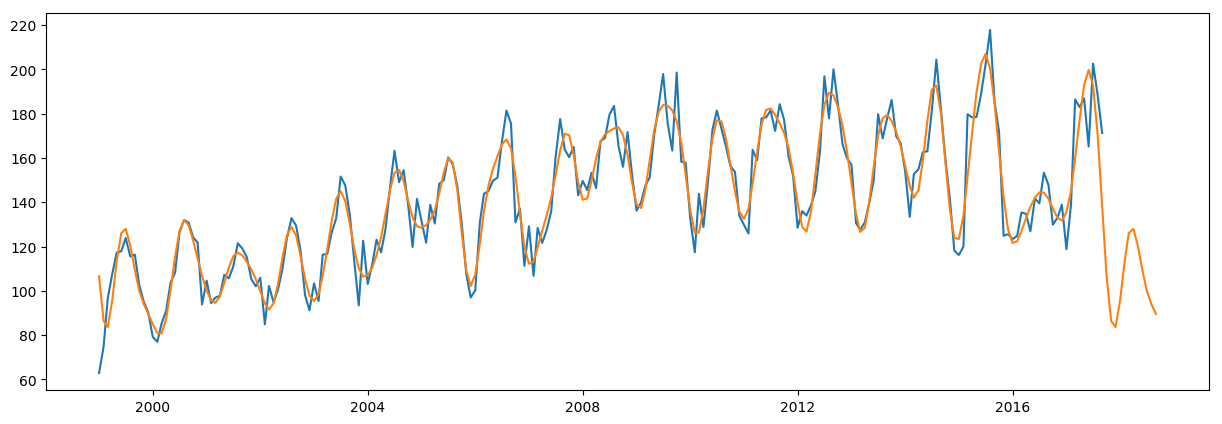

In [52]:
plt.plot(ts)
plt.plot(restored_fourier)

In [53]:
prediction_year = restored_fourier[-12:]
prediction_year

2017-10-01    106.550759
2017-11-01     86.335378
2017-12-01     83.618184
2018-01-01     95.795479
2018-02-01    113.450028
2018-03-01    126.074088
2018-04-01    127.980848
2018-05-01    120.503428
2018-06-01    109.419520
2018-07-01    100.061838
2018-08-01     94.007653
2018-09-01     89.552276
dtype: float64

## Resources planning

In [54]:
from scipy.optimize import minimize
import random

На 3 тони врожаю потрібно залучити 1 працівника
Працівників можна наймати, використовуючи 3 типи контрактів:
i) 3 місячний термін, страховий збір 300 у.о. на початку, мзп 1000 у.о. 
ii) 4 місячний термін, щомісячний страховий збір 110 у.о., мзп 900 у.о 
iii) 7 місячний термін, щомісячний страховий збір 110 у.о. перші 3 місяці і 90 у.о. наступні 4 місяці, бонус по завершенні контракту 100 у.о. мзп.800 

In [55]:
num_workers = np.round(prediction_year/3)
num_workers

2017-10-01    36.0
2017-11-01    29.0
2017-12-01    28.0
2018-01-01    32.0
2018-02-01    38.0
2018-03-01    42.0
2018-04-01    43.0
2018-05-01    40.0
2018-06-01    36.0
2018-07-01    33.0
2018-08-01    31.0
2018-09-01    30.0
dtype: float64

In [56]:
x = []
for i in range(12*3):
    x.append(random.randint(1, 9))

In [57]:
n = 12*3

def constraint_num_workers(x):
    arr = np.add.reduceat(x, np.arange(0, len(x), 3))      

    num_workers = [36, 29, 28, 32, 38, 42, 43, 40, 36, 33, 31, 30]
    sum_eq = []
    for i, w in enumerate(num_workers):
        sum_eq.append(w-arr[i])
    return np.min(sum_eq)

# x = x1_3months x1_4months x1_7months,  x2_3 x2_4, x2_7,  x3_3 x3_4 x3_7  x4_3 x4_4 x4_7, ...